In [181]:
from catemb.data import CatDataset
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from catemb import CatEmb
from copy import deepcopy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
catemb_calc1 = CatEmb(model_path='../code/save_model/260131-0413h_equif_plat_lr1e-4_decay_step5_temp0.1_EBM_dot_prod_xtbopt62755_equif_first_dim32_cl_kl_e_111_ln', device='cuda:0')

## 根据金属上色

In [182]:
dataset = CatDataset(root='../dataset/processed',name="lig_cat_dataset_xtbopt_178674",read_coord=True,save_smiles=True)
lig_cat_dataset = np.load('../dataset/processed/lig_cat_dataset.npy', allow_pickle=True)

In [194]:
len(dataset)

178674

In [193]:
len(lig_cat_dataset)

207617

In [188]:
lig_cat_dataset

array([{'smiles': '[O-]C1=[O]->[Mg]<-[NH]2CSC[C@@H]12'},
       {'smiles': '[O-]C1=[O]->[Sc]<-[NH]2CSC[C@@H]12'},
       {'smiles': '[O-]C1=[O]->[Ti]<-[NH]2CSC[C@@H]12'}, ...,
       {'smiles': 'CC(C)(C)c1cc2C=[N]3C4CCCCC4[N]4=Cc5cc(C(C)(C)C)cc(CN6CCOCC6)c5[OH]->[Ir]<-3<-4<-[OH]c2c(CN2CCOCC2)c1'},
       {'smiles': 'CC(C)(C)c1cc2C=[N]3C4CCCCC4[N]4=Cc5cc(C(C)(C)C)cc(CN6CCOCC6)c5[OH]->[Pt]<-3<-4<-[OH]c2c(CN2CCOCC2)c1'},
       {'smiles': 'CC(C)(C)c1cc2C=[N]3C4CCCCC4[N]4=Cc5cc(C(C)(C)C)cc(CN6CCOCC6)c5[OH]->[Au]<-3<-4<-[OH]c2c(CN2CCOCC2)c1'}],
      shape=(207617,), dtype=object)

In [189]:
smiles_lst = [data['smiles'] for data in lig_cat_dataset]
mol_lst = [Chem.MolFromSmiles(smiles) for smiles in smiles_lst]

In [190]:
metal_lst = ['Mg', 'Sc', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Ru', 'Rh', 'Pd', 'Ag', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Os', 'Ir', 'Pt', 'Au']

In [191]:
cat_smi_metal_map = {}
for smi, mol in zip(smiles_lst, mol_lst):
    dative_bonds = [bond for bond in mol.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.DATIVE]
    atoms_in_dative_bonds = [[bond.GetBeginAtom().GetSymbol(), bond.GetEndAtom().GetSymbol()] for bond in dative_bonds]
    if len(atoms_in_dative_bonds) > 0:
        atom_types = np.unique(np.concatenate(atoms_in_dative_bonds)).tolist()
        for metal in metal_lst:
            if metal in atom_types:
                cat_smi_metal_map[smi] = metal
                break

In [192]:
len(cat_smi_metal_map)

194820

In [6]:
cat_smi_lst = list(cat_smi_metal_map.keys())
cat_emb_arr = catemb_calc1.gen_desc(cat_smi_lst,batch_size=512)

In [8]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cat_emb_arr)
tsne = TSNE(n_components=2,random_state=42)
tsne_result = tsne.fit_transform(cat_emb_arr)

In [30]:
metal_color_map1 = {"Ni":"red","Pd":"yellow","Pt":"orange",
                   "Co":"blue","Rh":"royalblue","Ir":"skyblue"}
metal_color_map2 = {"Fe":"orange","Co":"red","Ni":"yellow","Cu":"coral",
                    "Ru":"blue","Rh":"skyblue","Pd":"royalblue","Ag":"lightblue"}
X = deepcopy(pca_result)
metal_color_map = deepcopy(metal_color_map1)
metal_desc_map = {}
for idx, (cat_smi, metal) in enumerate(cat_smi_metal_map.items()):
    if metal in metal_color_map:
        if not metal in metal_desc_map:
            metal_desc_map[metal] = [X[idx]]
        else:
            metal_desc_map[metal].append(X[idx])
for metal in metal_desc_map:
    metal_desc_map[metal] = np.array(metal_desc_map[metal])

In [25]:
metal_desc_map

{'Pt': array([[-105.262596 ,  -12.646062 ],
        [   6.2576313, -133.75897  ],
        [ -54.189976 ,  -55.730446 ],
        ...,
        [ -58.684967 ,  -59.525978 ],
        [ -41.655453 ,  145.92065  ],
        [  85.11471  ,   35.826115 ]], shape=(5684, 2), dtype=float32),
 'Ni': array([[ -7.569614 ,  51.392574 ],
        [-28.27161  , -17.024855 ],
        [ 29.768234 ,  71.60315  ],
        ...,
        [ 34.901478 ,  58.257885 ],
        [ -4.5297475,  82.20121  ],
        [ 71.51874  ,  -1.6781878]], shape=(5679, 2), dtype=float32),
 'Ir': array([[-88.68814 , -12.472004],
        [125.76123 ,  56.864914],
        [-16.672592,  82.95529 ],
        ...,
        [ 60.283997,  65.52299 ],
        [-10.144172, -89.50752 ],
        [ 88.13112 ,  32.196285]], shape=(5683, 2), dtype=float32),
 'Co': array([[ 39.36423  , -48.62475  ],
        [-69.64692  , -27.4188   ],
        [-32.941364 , -55.267036 ],
        ...,
        [-53.62612  ,  92.50638  ],
        [ 20.4417   , -63.1651

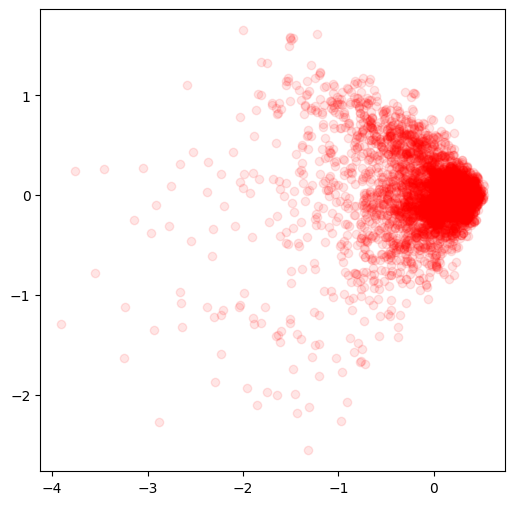

In [31]:
metal = 'Ni'
desc = metal_desc_map[metal]
plt.figure(figsize=(6,6))
plt.scatter(desc[:,0],desc[:,1],color=metal_color_map[metal],label=metal,alpha=0.1)

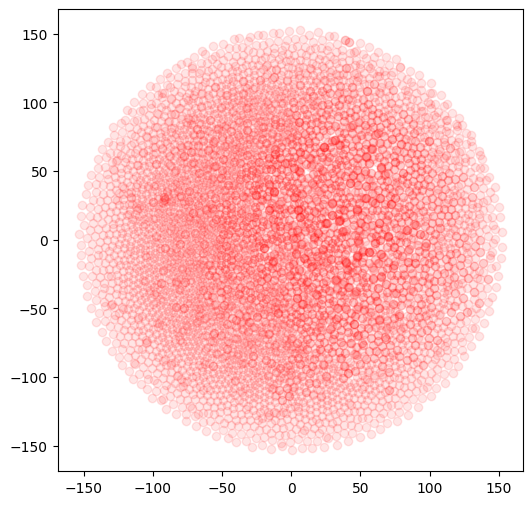

In [29]:
metal = 'Ni'
desc = metal_desc_map[metal]
plt.figure(figsize=(6,6))
plt.scatter(desc[:,0],desc[:,1],color=metal_color_map[metal],label=metal,alpha=0.1)

## 根据配体类型上色

In [46]:
lig_cat_dataset = np.load('../dataset/processed/lig_cat_dataset.npy', allow_pickle=True)

In [187]:
len(lig_cat_dataset)

207617

In [49]:
smiles_lst = []
mol_lst = []
for data in lig_cat_dataset:
    smiles_lst.append(data['smiles'])
    mol_lst.append(AllChem.AddHs(Chem.MolFromSmiles(data['smiles'])))

In [115]:
ligand_smarts_type_map = {'P-[#6,#7]~[#6]-[C;H0]1=N[C,c][C,c]O1':"PHOX",
                          'O=[SX3]([*:4])[N]([*:3])[C]([H])([*:1])([*:2]).[PX3]([#6])([#6])':"SadPhos",
                          '[*][SX3](N([*])[CX4;!R]([*])C1=CC=CC=C1[PX3]([#6])([#6]))=O':"SadPhos",
                          '[*][CX4;!R]([CX4;!R][PX3]([#6])[#6])N([*])[S@@X3]([*])=O':"SadPhos",
                          '[*]C1([*])C2=C(C([CX4;!R]([*])N(*)[S@@X3]([*])=O)=CC=C2)OC3=C([PX3]([#6])([#6]))C=CC=C31':"SadPhos",
                          'O1[C,c][C,c]N=[C]1~[#6]~[C]2=N[C,c][C,c]O2':"Box",
                          'O-c1ccccc1-C=[N,n]~[#6]~[#6]~[N,n]=C-c2ccccc2O':"Salen",
                          '[P]~[#6,c]~[P]':"Bisphos",
                          '[P]~[#6,c]~[#6,c]~[P]':"Bisphos",
                          '[P]~[#6,c]~[#6,c]~[#6,c]~[P]':"Bisphos",
                          '[P]~[#6,c]~[#6,c]~[#6,c]~[#6,c]~[P]':"Bisphos",
                          'P-c1c2ccccc2ccc1-c3c(P)ccc4ccccc34':"Bisphos",
                          'PC12C3C4C5C1[Fe]25436789C%10C6C7C8C%109P':"Bisphos",
                          '[P;H0](-[#6])([-#6])-[#6]~[#6]~[P;H0](-[#6])-[#6]':"Bisphos",
                          '[n,N,n+,N+]1~[c,C;H1]~[n,N,n+,N+]~[c,C]~[c,C]1':"NHC",
                          '[P;X3;H0;v3;!$(P=[O,S,N])](-[#6,c])(-[#6,c])-[#6,c]':"Monophos",
                          '[O-][N+]1(CCCCC1C=O)CCC[N+]2(C(C=O)CCCC2)[O-]':"N,N-Dioxide",
                          '[O-][N+]1(CCC[N+]2([O-])CCCC2C=O)CCCC1C=O':"N,N-Dioxide",
                          '[N][CX4][C](=[O])[O;H1]':"amino acid",
                          '[N][CX4][C](=[O])[O;H0-]':"amino acid",
                          '[P;X4;v5](=[O])([O;H1,H0-])([O,o])([O,o])':'Phos acid'
                          }
ligand_smarts_mol_map = {smarts:Chem.MolFromSmarts(smarts) for smarts in ligand_smarts_type_map}

In [116]:
lig_smi_type_map = {}
lig_smi_nometal_lst = []
for smi, mol in zip(smiles_lst, mol_lst):
    dative_bonds = [bond for bond in mol.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.DATIVE]
    #atoms_in_dative_bonds = [[bond.GetBeginAtom().GetSymbol(), bond.GetEndAtom().GetSymbol()] for bond in dative_bonds]
    if len(dative_bonds) == 0:
        lig_smi_nometal_lst.append(smi)
        for smarts, type_ in ligand_smarts_type_map.items():
            scaffold_mol = ligand_smarts_mol_map[smarts]
            if mol.HasSubstructMatch(scaffold_mol):
                if not smi in lig_smi_type_map:
                    lig_smi_type_map[smi] = [type_]
                else:
                    if 'Bisphos' in lig_smi_type_map[smi] and type_ == 'Monophos':
                        continue
                    lig_smi_type_map[smi].append(type_)
        
lig_type_smi_map = {}
for smi in lig_smi_type_map:
    for type_ in lig_smi_type_map[smi]:
        if not type_ in lig_type_smi_map:
            lig_type_smi_map[type_] = [smi]
        else:
            lig_type_smi_map[type_].append(smi)
lig_type_count_map = {}
for type_ in lig_type_smi_map:
    lig_type_count_map[type_] = len(lig_type_smi_map[type_])


In [117]:
lig_smi_lst = list(lig_smi_type_map.keys())
len(lig_smi_lst),len(lig_smi_nometal_lst),lig_type_count_map

(4785,
 12797,
 {'Monophos': 2349,
  'Bisphos': 269,
  'SadPhos': 1158,
  'Phos acid': 129,
  'amino acid': 1649,
  'NHC': 113,
  'Salen': 14,
  'PHOX': 81,
  'Box': 215,
  'N,N-Dioxide': 65})

In [170]:
lig_type_color_map = {'Monophos': 'lightcoral',
 'Bisphos': 'saddlebrown',
 'SadPhos': 'darkorange',
 'PHOX': 'lightgreen',
 'NHC': 'green',
 'Salen': 'deepskyblue',
 'Box': 'navy',
 'Phos acid': 'orchid',
 'amino acid': 'pink',
 'N,N-Dioxide':'gray'}

In [121]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
lig_desc = catemb_calc1.gen_desc(lig_smi_lst)
lig_pca = pca.fit_transform(lig_desc)
lig_tsne = tsne.fit_transform(lig_pca)

In [122]:
X = deepcopy(lig_tsne)
lig_type_x_map = {}
for idx in range(len(lig_smi_lst)):
    x = X[idx]
    smi = lig_smi_lst[idx]
    type_ = lig_smi_type_map[smi][0]
    if not type_ in lig_type_x_map:
        lig_type_x_map[type_] = [x]
    else:
        lig_type_x_map[type_].append(x)
lig_type_x_map = {type_: np.array(x_lst) for type_, x_lst in lig_type_x_map.items()}

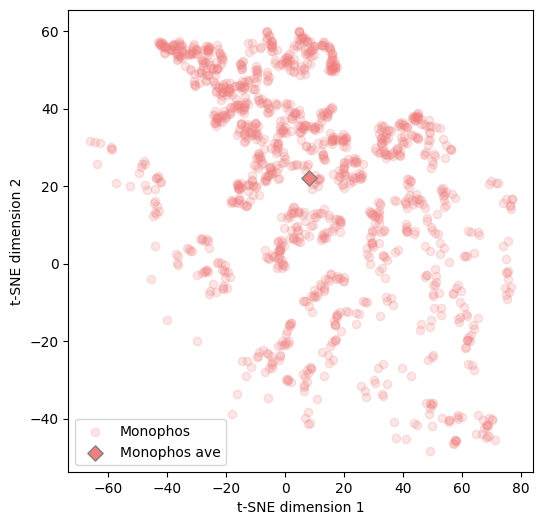

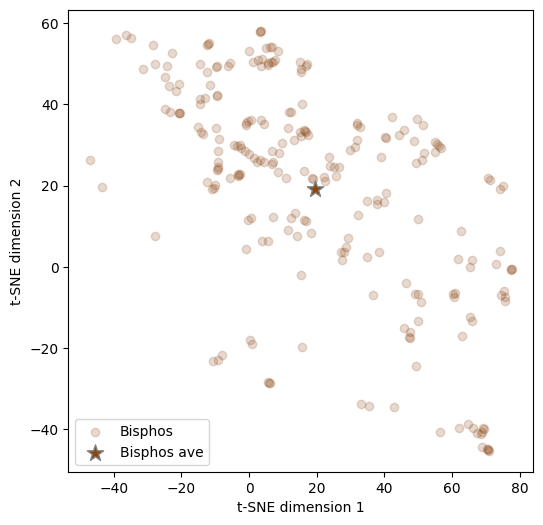

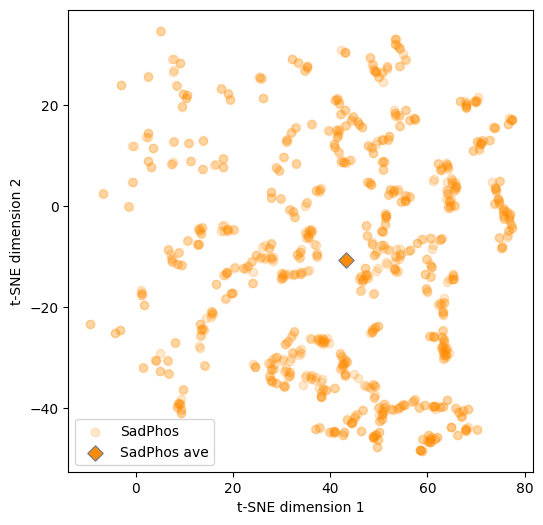

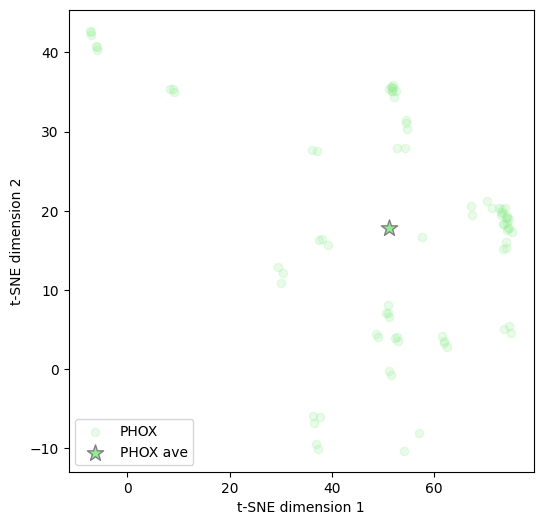

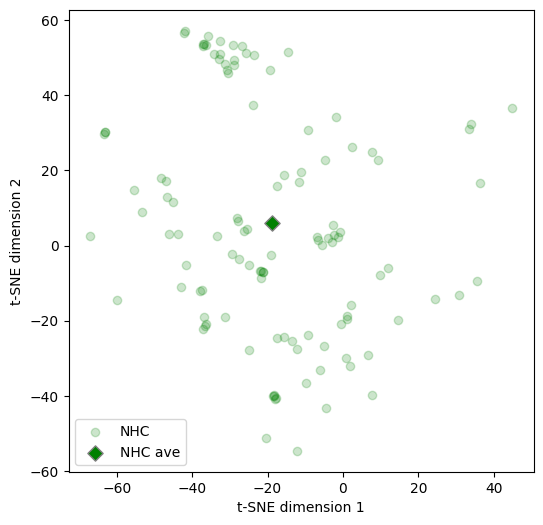

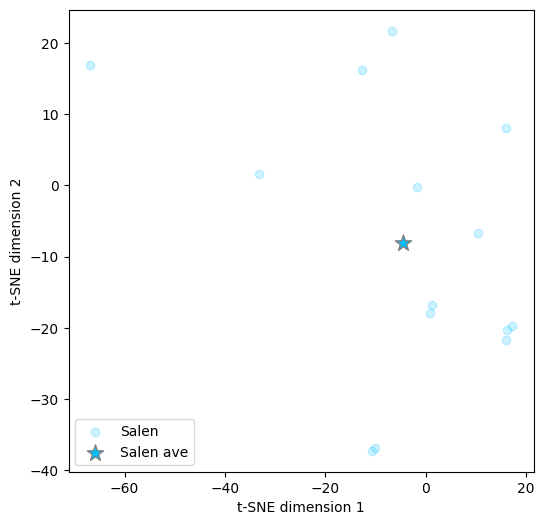

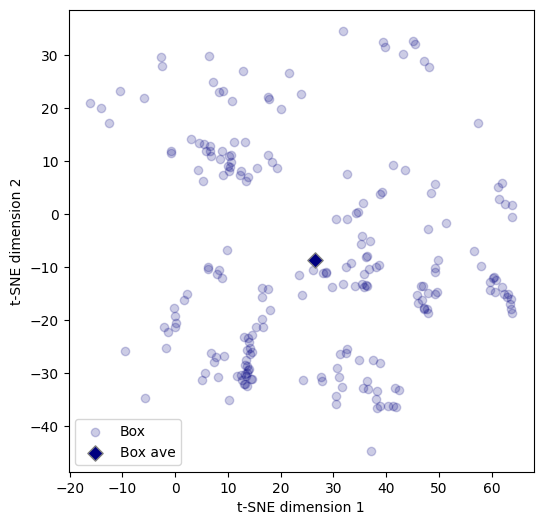

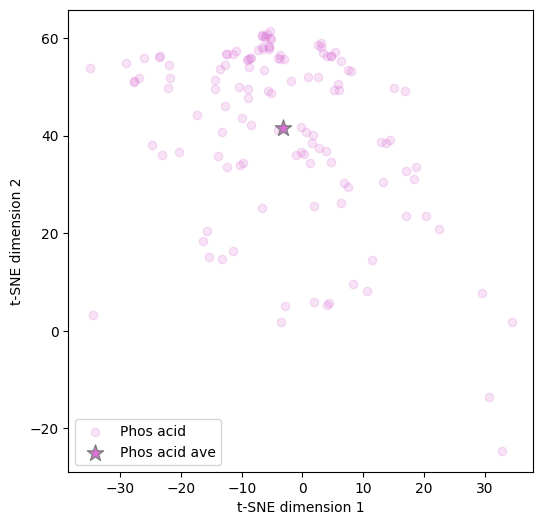

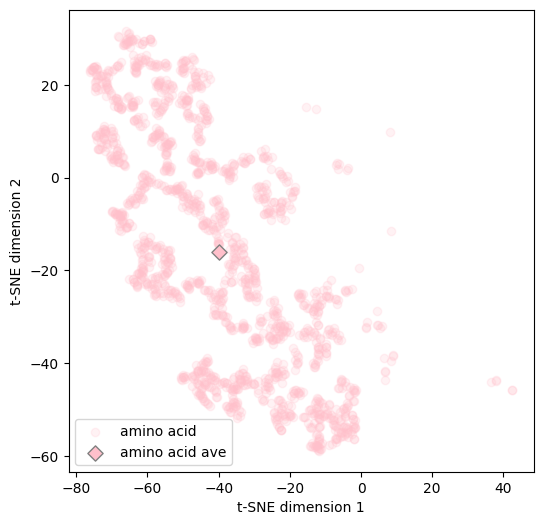

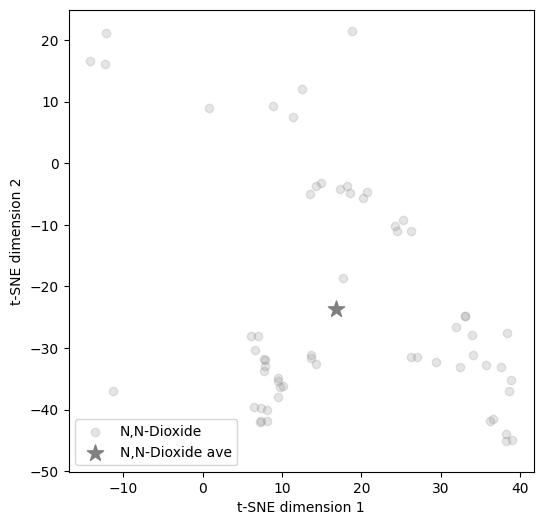

In [171]:
ct = 0
maker_type = ['D','*']
maker_size = [60,150]
lig_type_ave_x_map = {}
for idx,type_ in enumerate(lig_type_color_map.keys()):
    x_lst = lig_type_x_map[type_]
    plt.figure(figsize=(6,6))
    plt.scatter(x_lst[:,0],x_lst[:,1],color=lig_type_color_map[type_],label=type_,alpha=0.2)
    ave_0 = np.mean(x_lst[:,0])
    ave_1 = np.mean(x_lst[:,1])
    plt.scatter(ave_0,ave_1,color=lig_type_color_map[type_],label=type_+' ave',s=maker_size[idx%2],marker=maker_type[idx%2],edgecolors='gray')
    lig_type_ave_x_map[type_] = np.array([ave_0,ave_1])
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.legend(loc='lower left')

In [168]:
lig_type_color_map = {'Monophos': 'lightcoral',
 'Bisphos': 'saddlebrown',
 'SadPhos': 'darkorange',
 'PHOX': 'lightgreen',
 'NHC': 'green',
 'Salen': 'deepskyblue',
 'Box': 'navy',
 'Phos acid': 'orchid',
 'amino acid': 'pink',
 'N,N-Dioxide':'gray'}

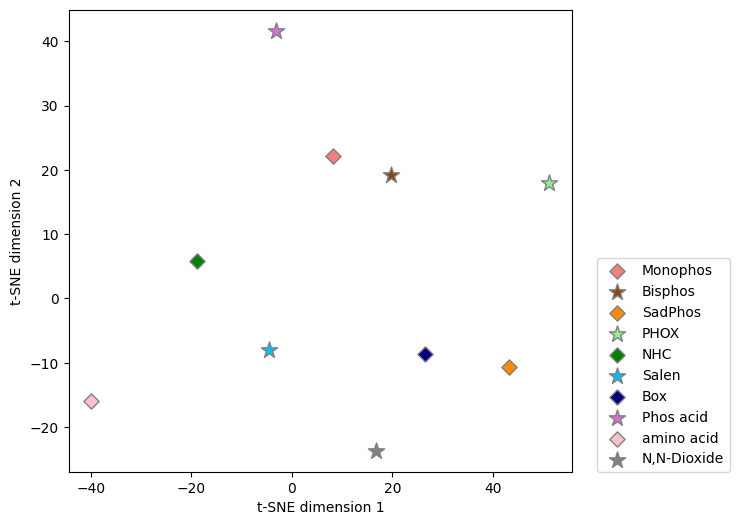

In [169]:
maker_type = ['D','*']
maker_size = [60,150]
plt.figure(figsize=(6.5,6))
for idx,type_ in enumerate(lig_type_color_map.keys()):
    x_arr = lig_type_ave_x_map[type_]
    plt.scatter(x_arr[0],x_arr[1],color=lig_type_color_map[type_],label=type_,s=maker_size[idx%2],marker=maker_type[idx%2],alpha=1,edgecolors='gray')
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(loc=(1.05,0))


<Axes: >

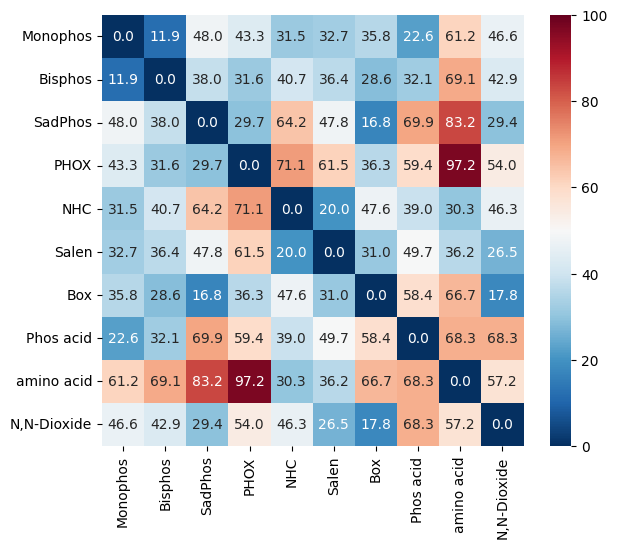

In [180]:
plt.figure(figsize=(6.8,5.6))
dist_mat = np.zeros((len(lig_type_ave_x_map),len(lig_type_ave_x_map)))
for idx1,type1 in enumerate(lig_type_ave_x_map):
    for idx2,type2 in enumerate(lig_type_ave_x_map):
        if idx1 == idx2:
            continue
        x1 = lig_type_ave_x_map[type1]
        x2 = lig_type_ave_x_map[type2]
        dist_mat[idx1,idx2] = np.linalg.norm(x1-x2)
sns.heatmap(dist_mat,annot=True,fmt='.1f',cmap='RdBu_r',xticklabels=lig_type_ave_x_map.keys(),yticklabels=lig_type_ave_x_map.keys(),vmin=0,vmax=100)